## Using Embeddings for Text Representation with Deep Learning Models 

In this kernel, i will show the steps neccessary to clean the text and ensure maximal text coverage when using embeddings to represent text in format suitable for Deep Learning models. 

We will discuss LSTM Architecture and how embeddings fit in to boost performance on NLP calssification tasks.

Finally, i will train couple of LSTM Neural Networks and compare performances.

References:
* https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/#more-engineered-features
* https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
* https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

In [3]:
#imports 
import os
import time
import math
import numpy as np
import pandas as pd
import re
import gc
import operator 
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout, Activation, CuDNNGRU, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

### Vocabulary and Coverage functions

Function to track our training vocabulary, which goes through all our text and counts the occurance of the contained words.

In [4]:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

Function that checks the intersection between our vocabulary and the embeddings. It will output a list of out of vocabulary (oov) words that we can use to improve our preprocessing

In [5]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

### Loading embeddings

In [6]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

There are words in embeddings that are known with upper letters but not know with lower letter. This functions adds lowercase words where word exist.

In [7]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [8]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [9]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)

Extracting GloVe embedding


### More Engineered Features

We can also add sentence specific features like sentence length, number of unique words etc. as another input layer to give extra information to the Deep Neural Network.

![alt text](../images/example_nlp_network_eenginener_features.png "Deep NN with extra features.")

> This is advanced architecture and I dind't have time to experiment with it.

Reference: 
* https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/#more-engineered-features



In [10]:
def add_features(df):
    df['question_text'] = df['question_text'].apply(lambda x:str(x))
    df["lower_question_text"] = df["question_text"].apply(lambda x: x.lower())
    df['total_length'] = df['question_text'].apply(len)
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    return df

## Data Preparation and Cleaning

Basic Preprocessing Techniques for text data:
* Cleaning Special Characters and Removing Punctuations
* Cleaning Numbers
* Removing Misspells
* Removing Contractions

Difference in preprocessing compared to conventional methods is that:
1. we don't use standard preprocessing steps like stemming or stopword removal as we loose valuable information
1. we need to get our corpus vocabulary as close as to the embeddings as possible

So, here goal of preprocessing is to increase embeddings coverage, i.e. to have most words in our corpus covered by pretrained embeddings. 

## Load data

In [11]:
train_df = pd.read_csv("../input/train.csv")#[:100000]
print("Train shape : ",train_df.shape)

Train shape :  (1306122, 3)


In [12]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [13]:
# here we could add features to describe some characteristics of the the question
#train_df = add_features(train_df).head()

### Starting point
Check how many words in our corpus are covered by embeddings

In [14]:
vocab = build_vocab(train_df['question_text'])

In [15]:
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 33.02% of vocab
Found embeddings for  88.15% of all text


Only 33% of our vocabulary will have embeddings, making 12% of our data more or less useless. So lets have a look and start improving. For this we can easily have a look at the top oov words.

Let's have all words in lowercase. We lost a bit of information but it makes it easier to clean the misspells later. We'll also expand embeddings file with words in lower case when word already exists but with capitalized letters.

In [16]:
train_df['lowered_question'] = train_df['question_text'].apply(lambda x: x.lower())

In [17]:
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
add_lower(embed_glove, vocab)
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 33.02% of vocab
Found embeddings for  88.15% of all text
Added 14725 words to embedding
Found embeddings for 33.28% of vocab
Found embeddings for  88.16% of all text


Coverage improved a bit. Let's see what is wrong?

In [18]:
oov_glove[:10]

[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386)]

First faults appearing are :
* Contractions
* Words with punctuation in them

#### Contractions and Special Characters

In [19]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [20]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [21]:
print("- Known Contractions -")
print("   Glove :")
print(known_contractions(embed_glove))

- Known Contractions -
   Glove :
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]


Not a lot of contractions are known in embeddings. So, let's replace them in our corpus. 

In [22]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [23]:
train_df['treated_question'] = train_df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [24]:
vocab = build_vocab(train_df['treated_question'])
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 30.79% of vocab
Found embeddings for  88.56% of all text


Small improvemnt in words found in embedding, we lost a bit of coverage due to lowercase of all words. Now, let us deal with special characters.

In [25]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [26]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [27]:
print("- Unknown Contractions -")
print("   Glove :")
print(unknown_punct(embed_glove, punct))

- Unknown Contractions -
   Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 


Some characters are unknown in embeddings. So we need to modify our corpus to include only known ones:
* replace unknown characters with known ones
* make sure to have spaces between words and punctuation

In [28]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [29]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [30]:
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [31]:
vocab = build_vocab(train_df['treated_question'])
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 69.52% of vocab
Found embeddings for  99.58% of all text


Nice! We've imporved coverage and now almost 70% of our vocabulary is covered by embeddings, making 0.5% of our data uncovered. Let's have a look at the top oov words.

In [32]:
oov_glove[:100]

[('quorans', 858),
 ('brexit', 524),
 ('cryptocurrencies', 499),
 ('redmi', 383),
 ('coinbase', 149),
 ('oneplus', 139),
 ('uceed', 123),
 ('demonetisation', 115),
 ('bhakts', 115),
 ('upwork', 111),
 ('pokémon', 109),
 ('machedo', 108),
 ('gdpr', 107),
 ('adityanath', 106),
 ('boruto', 102),
 ('bnbr', 100),
 ('alshamsi', 92),
 ('dceu', 90),
 ('litecoin', 87),
 ('iiest', 86),
 ('unacademy', 86),
 ('sjws', 84),
 ('qoura', 82),
 ('zerodha', 80),
 ('tensorflow', 74),
 ('fiancé', 73),
 ('doklam', 70),
 ('kavalireddi', 69),
 ('lnmiit', 68),
 ('muoet', 66),
 ('nicmar', 62),
 ('vajiram', 60),
 ('adhaar', 59),
 ('zebpay', 58),
 ('elitmus', 57),
 ('srmjee', 56),
 ('hackerrank', 54),
 ('altcoin', 54),
 ('altcoins', 54),
 ('jiren', 52),
 ('awdhesh', 52),
 ('ryzen', 50),
 ('koinex', 48),
 ('baahubali', 48),
 ('mhcet', 45),
 ('binance', 45),
 ('byju', 44),
 ('srmjeee', 42),
 ('beerus', 41),
 ('ftre', 40),
 ('skripal', 40),
 ('sgsits', 40),
 ('mhtcet', 38),
 ('hotstar', 38),
 ('gurugram', 38),
 ('na

What's still missing ?
* Unknown words
* Acronyms
* Spelling mistakes

#### Manually correct  most frequent mispells

For example, here are some mistakes and their frequency:
* demonetisation: 115 times
* qoura : 82 times
* fiancé : 73 times
* demonitisation : 29 times
* ...

In [33]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'qoura': 'quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

In [34]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [35]:
# Clean misspellings
train_df["treated_question"] = train_df["treated_question"].apply(lambda x: correct_spelling(x, mispell_dict))

In [36]:
vocab = build_vocab(train_df['treated_question'])
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 69.52% of vocab
Found embeddings for  99.58% of all text


Great, we've imporved coverage even more and now only 0.4% of our data uncovered. Let's have a look at the top oov words.

In [37]:
oov_glove[:20]

[('quorans', 858),
 ('brexit', 524),
 ('cryptocurrencies', 499),
 ('redmi', 383),
 ('coinbase', 149),
 ('oneplus', 139),
 ('uceed', 123),
 ('bhakts', 115),
 ('upwork', 111),
 ('machedo', 108),
 ('gdpr', 107),
 ('adityanath', 106),
 ('boruto', 102),
 ('bnbr', 100),
 ('alshamsi', 92),
 ('dceu', 90),
 ('litecoin', 87),
 ('iiest', 86),
 ('unacademy', 86),
 ('sjws', 84)]

We can additinally convert some object names to generic items:
* cryptocurrencies: cryptocurrency,
* coinbase: 'marketplace',
* quorans: 'comunity',
* redmi , oneplus: 'mobilephone',
* gdpr: regulation,
* litecoin -> cryptocurrency
* fortnite, pubg -> game

In [38]:
generic_words= { 'cryptocurrencies': 'cryptocurrency', 'coinbase': 'marketplace', 'quorans': 'comunity', 'redmi': 'mobilephone',
                 'oneplus': 'mobilephone', 'gdpr': 'regulation', 'litecoin': 'cryptocurrency' 
}

In [39]:
# Replace with generic words
train_df["treated_question"] = train_df["treated_question"].apply(lambda x: correct_spelling(x, generic_words))

In [40]:
vocab = build_vocab(train_df['treated_question'])
print("Coverage with Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Coverage with Glove : 
Found embeddings for 69.52% of vocab
Found embeddings for  99.59% of all text


In [41]:
oov_glove[:20]

[('brexit', 524),
 ('uceed', 123),
 ('bhakts', 115),
 ('upwork', 111),
 ('machedo', 108),
 ('adityanath', 106),
 ('boruto', 102),
 ('bnbr', 100),
 ('alshamsi', 92),
 ('dceu', 90),
 ('iiest', 86),
 ('unacademy', 86),
 ('sjws', 84),
 ('qoura', 82),
 ('zerodha', 80),
 ('tensorflow', 74),
 ('fiancé', 73),
 ('doklam', 70),
 ('kavalireddi', 69),
 ('lnmiit', 68)]

Looks good, no obvious words we could easily fix. 

## Representing Data as Sequences

Since machines cannot understand words they expect data in numerical form. So we would need to represent text data as a series of numbers. 

We will do this in few steps:
1. __Tokenization__ - basically it splits a sentence into words. The tokenizer once fitted to the data also keeps an index of words (dictionary of words which we can use to assign a unique number to a word).
    * e.g., "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
    * with index, e.g., {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
    * each senteces is represented as this chain of index and feed into our LSTM, e.g., [1,2,3,4,2,5]
2. __Padding__ - machine learning model expects that each sequence (each question) will be of the same length (same number of words/tokens), so we pad all questions to desired length, i.e. fill shorter questions with zeros, and trim longer questions to maxlen
    * question #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
    * question #2: [1,2]
3. __Embedding__ - embedding is a dictionary in which the key is the word and the value is the word vector, a np.array of length 300. Embedding is matrix of words that exits in our text will be used by Deep Learning network to make sense of the sentence.


__Check length of sentences to determine suitable maxlen__

In [42]:
totalNumWords = train_df.question_text.str.count('\S+')

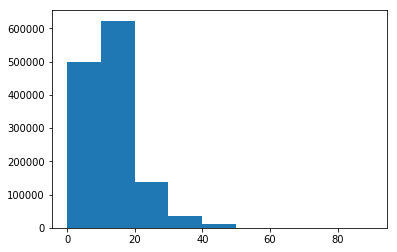

In [43]:
plt.hist(totalNumWords,bins = np.arange(0,100,10))
plt.show()

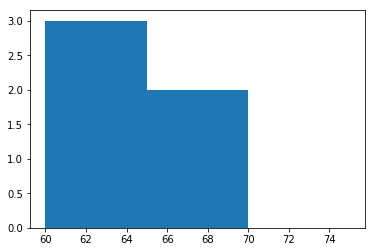

In [44]:
# Check right tail
plt.hist(totalNumWords,bins = np.arange(60,80,5))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the questions have about 20 words. We could set the "maxlen" to 20, but to have better representation for longer questions let's set it to 70 to cover all words in question. But, this is something we could experiment and see what is the best number.

### Basic parameters

In [45]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug =0

#### Tokenize and pad sequences
As discussed above, this step splits questions into words, represents questions as sequences words by using word_index and pads all sequences to same length.

In [46]:
def tokenize_pad(X):
    t = Tokenizer(num_words=max_features)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=maxlen)
    return X, t.word_index

X, word_index = tokenize_pad(train_df['treated_question'])

In [47]:
## Get the target values
y = train_df['target'].values

In [48]:
# Split to train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.08, random_state=2018)

In [49]:
print(f"Training on {X_train.shape[0]} texts")
print(f"Validating on {X_val.shape[0]} texts")

Training on 1201632 texts
Validating on 104490 texts


#### Embeddings

This is an advanced step to enrich embeddings. We use GLoVE pretrained vectors which are trained on the Wikipedia corpus. So, some of the words that might be present in our data might not be present in the embeddings. To enrich them we can:
* convert the words to lowercase in embedding (‘USA’, ‘usa’ and ‘Usa’)
* derive value by adding extra information to the embeddings using some _domain knowledge_
* adding _polarity_ and _subjectivity_ of a word from the TextBlob package


In [50]:
from textblob import TextBlob
def make_enriched_embed_matrix(word_index,embeddings_index):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()    
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size+2))
    
    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        word_sent = TextBlob(word).sentiment
        # Extra information we are passing to our embeddings
        extra_embed = [word_sent.polarity,word_sent.subjectivity]
        if embedding_vector is not None: 
            embedding_matrix[i] =  np.append(embedding_vector,extra_embed)
        else:
            if word.islower():
                # Try to get the embedding of word in titlecase if lowercase is not present
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = np.append(embedding_vector,extra_embed)
                else:
                    embedding_matrix[i,300:] = extra_embed
                    count_found-=1
            else:
                embedding_matrix[i,300:] = extra_embed
                count_found-=1
    print("Got embedding for ",count_found," words.")
    return embedding_matrix

In [51]:
# create enriched embedding matrix from our data
embedding_matrix_plus = make_enriched_embed_matrix(word_index, embed_glove)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 195927/195927 [00:58<00:00, 3323.93it/s]


Got embedding for  101676  words.


In [52]:
# Set embedding size parmater to new value after enrichement
embed_size_plus = np.shape(embedding_matrix_plus)[1]
print("Enriched embedding matrix has {} words, and each word is represented by {}-dimensional vector."
      .format(np.shape(embedding_matrix_plus)[0], embed_size_plus))

Enriched embedding matrix has 120000 words, and each word is represented by 302-dimensional vector.


This is function to create classical embedding matrix, without enrichment.

In [53]:
def make_embed_matrix(word_index,embeddings_index):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] =  embedding_vector
        else:
                count_found-=1
    print("Got embedding for ",count_found," words.")
    return embedding_matrix

In [54]:
embedding_matrix = make_embed_matrix(word_index, embed_glove)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
100%|██████████| 195927/195927 [00:00<00:00, 431206.28it/s]


Got embedding for  99114  words.


In [55]:
print("Standard embedding matrix has {} words, and each word is represented by {}-dimensional vector."
      .format(len(embedding_matrix), embed_size))

Standard embedding matrix has 120000 words, and each word is represented by 300-dimensional vector.


In [56]:
gc.collect()

1487

Now we have everything ready to start modeling.

## Creating Deep Learning models

Here we will define few Deep Learning models that perform well with NLP tasks. Typical configuration of used Deep Network is:

![Arcitecture of LSTM Neural Network](../images/lstm.png "LSTM")

#### Input
The inputs into our networks are our list of encoded sentences. We begin our model by defining an Input layer that accepts a list of sentences that has a dimension of 70 (maxlen).
> `inp = Input(shape=(maxlen,))`

By indicating an empty space after comma, we are telling Keras to infer the number for size of sentences list automatically, that is our batch_size.

#### Embedding layer
With Embeddings we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.

The output of the Embedding layer is just a list of the coordinates of the words in this vector space. 

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) and the size of vector representing each word (embed_size) we are using. Again, the embedding size is a parameter that you can tune and experiment.

> `x = Embedding(max_features, embed_size)(inp)`

The embedding layer outputs a 3-D tensor of (None, 70, 300). Which is an array of sentences(None means that it's size is inferred), and for each word(70), there is an array of 300 coordinates in the vector space of embedding.

#### LSTM
LSTM in its core, preserves information from inputs that has already passed through it using the hidden state.

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

From the above picture, the unrolled LSTM would give us a set of h0,h1,h2 until the last h.

LSTM takes in a tensor of `[Batch Size, Time Steps, Number of Inputs]`. Batch size is the number of samples in a batch, time steps is the number of recursions it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

> `x = LSTM(60, return_sequences=True, name='lstm_layer')(x)`

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 70, 300) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 70 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 70, 60), where 60 is the output dimension we have defined.

#### Max Pooling
Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

This is role of Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

> `x = GlobalMaxPool1D()(x)`

#### Dropout
With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization, i.e. less prone to overfitting. Again, Dropout value is parameter that we can tune and experiment.

> `x = Dropout(0.1)(x)`

#### Dense Layer
After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

$$Activation((Input \times Weights) + Bias)$$

We have defined the Dense layer to produce a output dimension of 50.

> `x = Dense(16, activation="relu")(x)`

We feed the output into a Dropout layer again

> `x = Dropout(0.1)(x)`

#### Output
Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for our label, and the sigmoid function will squash the output between the bounds of 0 and 1.

> `x = Dense(1, activation="sigmoid")(x)`

#### Compile
All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using `Adam` optimizer, define the loss function to be `"binary_crossentropy"` since we are tackling a binary classification.

>`model = Model(inputs=inp, outputs=x)`

> `model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])`

#### LSTM Model #1 Definition
Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past.

In [57]:
def model_lstm_uni(embedding_matrix, _dropout=0.1):
    max_features = np.shape(embedding_matrix)[0]
    embed_size = np.shape(embedding_matrix)[1]
        
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = CuDNNLSTM(60, return_sequences=True, name='lstm_layer')(x) # GPU
    #x = LSTM(60, return_sequences=True, name='lstm_layer')(x)     # CPU
    x = GlobalMaxPool1D()(x)
    x = Dropout(_dropout)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(_dropout)(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

#### LSTM Model #2 Definition
Bidirectional LSTM runs inputs in two ways, one from past to future and one from future to past. Bu using the two hidden states combined BiLSTM are able in any point in time to preserve information from both past and future.

In [58]:
def model_lstm_bi(embedding_matrix, _dropout=0.1):
    max_features = np.shape(embedding_matrix)[0]
    embed_size = np.shape(embedding_matrix)[1]
        
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(60, return_sequences=True, name='lstm_layer'))(x) # GPU
    #x = Bidirectional(LSTM(60, return_sequences=True, name='lstm_layer'))(x)     # CPU
    x = GlobalMaxPool1D()(x)
    x = Dropout(_dropout)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(_dropout)(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

#### Helper Functions

In [59]:
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in np.arange(0.1, 0.501, 0.01):
        tmp[1] = metrics.f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta , tmp[2]

In [60]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, n_epochs=1):
    model.fit(X_train, y_train, batch_size=512, epochs=n_epochs, validation_data=(X_val, y_val))
    pred_y_val = model.predict([X_val], batch_size=1024, verbose=1)

    theshold, score = bestThresshold(y_val, pred_y_val)
    
    return pred_val_y, score

In [61]:
def plot_history(history):
    fig = plt.figure(figsize=(12,6)) 
    
    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show()

## Experimenting
Let's start training models and check performance.

### LSTM

In [62]:
lstm_uni = model_lstm_uni(embedding_matrix)
print(lstm_uni.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           36000000  
_________________________________________________________________
lstm_layer (CuDNNLSTM)       (None, 70, 60)            86880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)      

In [63]:
history = lstm_uni.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1201632 samples, validate on 104490 samples
Epoch 1/5
1201632/1201632 [==============================] - 28s 24us/step - loss: 0.1188 - acc: 0.9537 - val_loss: 0.1057 - val_acc: 0.9573
Epoch 2/5
1201632/1201632 [==============================] - 25s 21us/step - loss: 0.1052 - acc: 0.9585 - val_loss: 0.1021 - val_acc: 0.9590
Epoch 3/5
1201632/1201632 [==============================] - 25s 21us/step - loss: 0.1008 - acc: 0.9599 - val_loss: 0.1009 - val_acc: 0.9587
Epoch 4/5
1201632/1201632 [==============================] - 25s 21us/step - loss: 0.0976 - acc: 0.9611 - val_loss: 0.0991 - val_acc: 0.9599
Epoch 5/5
1201632/1201632 [==============================] - 25s 21us/step - loss: 0.0950 - acc: 0.9618 - val_loss: 0.0984 - val_acc: 0.9600


In [64]:
pred_y_val = lstm_uni.predict([X_val], batch_size=1024, verbose=1)
delta, _ = bestThresshold(y_val, pred_y_val)

104490/104490 [==============================] - 1s 8us/step
best threshold is 0.3600 with F1 score: 0.6820


We've got **F1-Score of 0.6802** without any tuning! This is great improvement over classical machine learning models which we explored in previous kernel and shows power of embeeding and Deep Learning in NLP tasks.

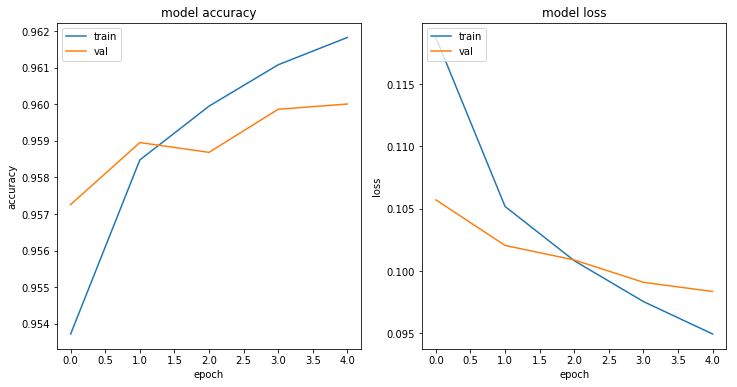

In [65]:
plot_history(history)

### LSTM + enriched embeddings

In [66]:
lstm_uni_enric = model_lstm_uni(embedding_matrix_plus)
print(lstm_uni_enric.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 302)           36240000  
_________________________________________________________________
lstm_layer (CuDNNLSTM)       (None, 70, 60)            87360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [67]:
history = lstm_uni_enric.fit(X_train, y_train, batch_size=512, epochs=4, validation_data=(X_val, y_val))

Train on 1201632 samples, validate on 104490 samples
Epoch 1/4
1201632/1201632 [==============================] - 27s 22us/step - loss: 0.1177 - acc: 0.9541 - val_loss: 0.1052 - val_acc: 0.9577
Epoch 2/4
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.1048 - acc: 0.9585 - val_loss: 0.1012 - val_acc: 0.9594
Epoch 3/4
1201632/1201632 [==============================] - 27s 22us/step - loss: 0.1005 - acc: 0.9600 - val_loss: 0.1000 - val_acc: 0.9596
Epoch 4/4
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.0973 - acc: 0.9610 - val_loss: 0.0989 - val_acc: 0.9599


In [68]:
pred_y_val = lstm_uni_enric.predict([X_val], batch_size=1024, verbose=1)
delta, _ = bestThresshold(y_val, pred_y_val)

104490/104490 [==============================] - 1s 9us/step
best threshold is 0.2700 with F1 score: 0.6802


We've got **F1-Score of 0.6820** without any tuning and only 4 epochs! Comparing to first model, we see that enriched embedding give small boost in performance. Let's try with larger Dropout rate, to be less prone to overfitting.

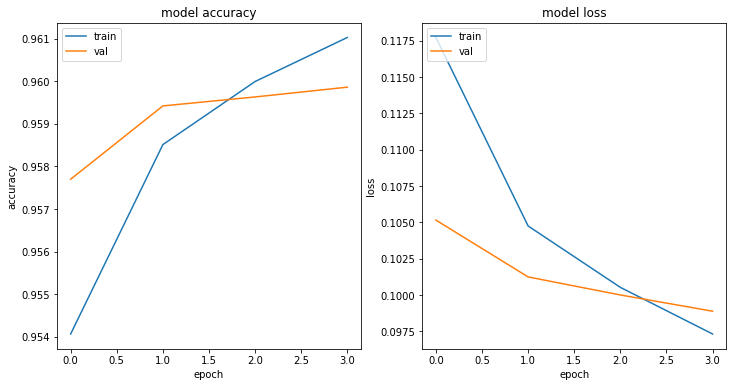

In [69]:
plot_history(history)


### LSTM + enriched embeddings + Dropout(0.5)

In [70]:
lstm_uni_enric_drop = model_lstm_uni(embedding_matrix_plus, _dropout=0.5)
print(lstm_uni_enric.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 302)           36240000  
_________________________________________________________________
lstm_layer (CuDNNLSTM)       (None, 70, 60)            87360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [71]:
history = lstm_uni_enric_drop.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_val, y_val))

Train on 1201632 samples, validate on 104490 samples
Epoch 1/5
1201632/1201632 [==============================] - 27s 22us/step - loss: 0.1284 - acc: 0.9511 - val_loss: 0.1085 - val_acc: 0.9558
Epoch 2/5
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.1130 - acc: 0.9559 - val_loss: 0.1045 - val_acc: 0.9579
Epoch 3/5
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.1089 - acc: 0.9573 - val_loss: 0.1027 - val_acc: 0.9585
Epoch 4/5
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.1060 - acc: 0.9582 - val_loss: 0.1045 - val_acc: 0.9585
Epoch 5/5
1201632/1201632 [==============================] - 26s 22us/step - loss: 0.1040 - acc: 0.9588 - val_loss: 0.1019 - val_acc: 0.9587


In [72]:
pred_y_val = lstm_uni_enric_drop.predict([X_val], batch_size=1024, verbose=1)
delta, _ = bestThresshold(y_val, pred_y_val)

104490/104490 [==============================] - 1s 9us/step
best threshold is 0.2500 with F1 score: 0.6768


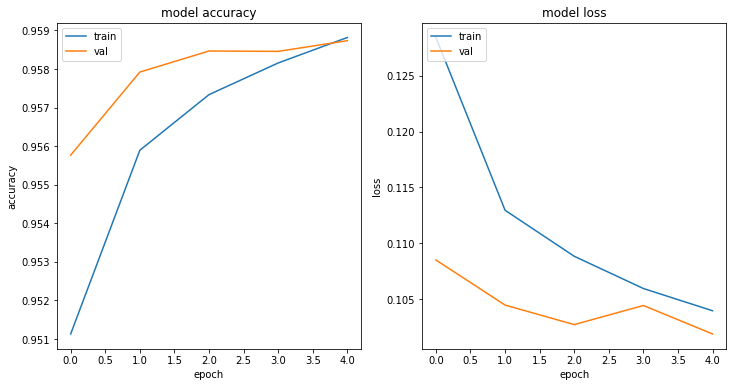

In [73]:
plot_history(history)


We've got **F1-Score of 0.6768** with increased Dropout and 5 epochs. By looking at the loss we see that it is decreasing so we need could use more epochs. We also see training and validation curves converging which means that the model is not overfitting to the training set and could be trained oevr more epochs.

Comparing to previous model, we've got small decrease in performance. Let's try with bidirectional LSTM.

### Bidictional LSTM + enriched embeddings

In [74]:
lstm_bi_enric = model_lstm_bi(embedding_matrix_plus)
print(lstm_bi_enric.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 70, 302)           36240000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 120)           174720    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

In [75]:
history = lstm_bi_enric.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_val, y_val))

Train on 1201632 samples, validate on 104490 samples
Epoch 1/5
1201632/1201632 [==============================] - 49s 41us/step - loss: 0.1155 - acc: 0.9548 - val_loss: 0.1027 - val_acc: 0.9588
Epoch 2/5
1201632/1201632 [==============================] - 48s 40us/step - loss: 0.1021 - acc: 0.9592 - val_loss: 0.0993 - val_acc: 0.9603
Epoch 3/5
1201632/1201632 [==============================] - 48s 40us/step - loss: 0.0968 - acc: 0.9611 - val_loss: 0.0983 - val_acc: 0.9604
Epoch 4/5
1201632/1201632 [==============================] - 48s 40us/step - loss: 0.0930 - acc: 0.9624 - val_loss: 0.0972 - val_acc: 0.9608
Epoch 5/5
1201632/1201632 [==============================] - 48s 40us/step - loss: 0.0892 - acc: 0.9639 - val_loss: 0.0967 - val_acc: 0.9610


In [76]:
pred_y_val = lstm_bi_enric.predict([X_val], batch_size=1024, verbose=1)
delta, _ = bestThresshold(y_val, pred_y_val)

104490/104490 [==============================] - 2s 16us/step
best threshold is 0.3800 with F1 score: 0.6904


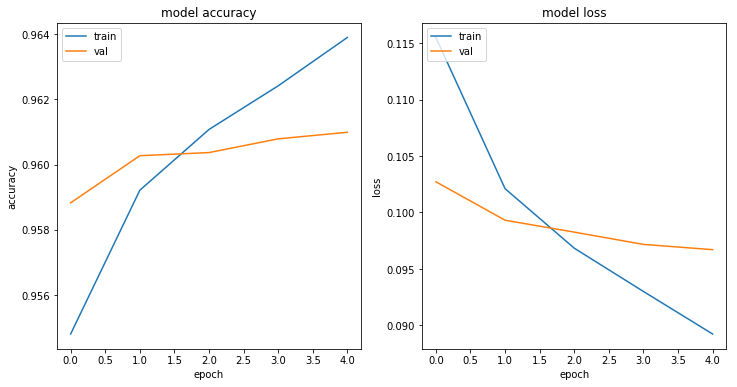

In [77]:
plot_history(history)

We've got best score yet **F1-Score of 0.6904** with Bidirectional LSTM without tuning and only 5 epochs. By looking at the loss we see that it is decreasing so we need could use more epochs, but we also see training and validation curves diverging which means that the model is overfitting to the training set, so we should tune Dropout in combination with more epochs.

## Parameter tuning for a LSTM with Hyperopt

When considering tuning parameters for LSTM we could think about tuning the following:
* choice of embeddings to use
* batchsize
* network architecture
    * LSTM hidden state size
    * LSTM layer number
    * Dropout rate 
    * Dense layer

Below are functions for tuning the network in such way, but due to time and resource constraints this exercise was not done.

In [ ]:
def model_lstm_bi_tuning(embedding_matrix, _LSTM_states=60, _dropout=0.1, _dense=50):
    max_features = np.shape(embedding_matrix)[0]
    embed_size = np.shape(embedding_matrix)[1]
        
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(60, return_sequences=True, name='lstm_layer'))(x) # GPU
    #x = Bidirectional(LSTM(60, return_sequences=True, name='lstm_layer'))(x)     # CPU
    x = GlobalMaxPool1D()(x)
    x = Dropout(_dropout)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(_dropout)(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
def objective(params):
    # extract parameters for evaluation
    embedding_matrix = params['embedding_matrix']
    batch_size = int(params['batch_size'])
    _LSTM_states = int(params['_LSTM_states'])
    _dropout = params['_dropout']
    _dense = params['_dense']
        
    # create model with parametrised acrhitecture
    model = model_lstm_bi_tuning(embedding_matrix, _LSTM_states, _dropout, _dense)
    
    # fit model with cross-validation
    model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_val, y_val))
    
    # predict on validation set
    pred_y_val = model.predict([X_val], batch_size=1024, verbose=1)
    delta, score = bestThresshold(y_val, pred_y_val)

    loss = 1 - score  # objective function returns loss to be minimized
    print("Loss {:.3f} params {}".format(loss, params))
      
    return loss

In [ ]:
space = {
    'embedding_matrix': hp.choice('embedding_matrix': [embedding_matrix, embedding_matrix_plus]),
    'batch_size': hp.quniform('batch_size', 128, 2048, 128),
    '_LSTM_states': hp.quniform('_LSTM_states', 20, 70, 5),
    '_dropout': hp.quniform('_dropout', 0.1, 0.8, 0.1),
    '_dense': hp.quniform('_dense', 20, 50, 5)
}

best_lgm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

## Conclusion

LSTM Neural Networks in combination with embeddings give significant boost in performance over conventional methods (TDIDF, CountVectors, Hashing) and classical machine learning algorithms.

By tuning network architecture better results can be achieved, but it takes a lot of time.

To furhter explore possibilities we could:
* tune hyper-parameters by running Bayes optimization of GPU enabled server
* experiment with different architectures: GRU, Extra features after BiLSTM, ...
* train on more epochs and introduce early stopping
* configure ensembles of multiple algorithms after tuning them
